In [1]:
from astropy.io import fits
import numpy as np
import scipy.stats
from scipy.stats import norm
from astropy.coordinates import Angle
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob

In [ ]:
def fits_data_index(fits_file: str):
    '''
    Finds the location of a FITS file's data array.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file to be searched.

    Returns
    -------
    int
        The index of the data array in the FITS file.
    '''

    file_index = 0

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    info = file[file_index]
    data = info.data
    while data is None:
        #going through the indices of file to find the array
        try:
            file_index += 1
            info = file[file_index]
            data = info.data
        except:
            print(f'Error in locating data index of {fits_file}')

    return file_index

In [ ]:
def region_stats(fits_file: str, center: list = [], radius: list = [], invert: bool = False):
    '''
    Finds the statistics of a region.

    Parameters
    ----------
        fits_file : str
            The path of the FITS file that contains the image.
        center : list
            A list of center coordinates in units of pixels.
            If center coordinates are given, then defaults to ((length of x-axis)/2, (length of y-axis)/2), rounded up.
        radius : list
            A list of search radii in units of arcsec.
        invert : bool
            Whether to swap the inclusion and exclusion regions.

    Returns
    -------
        dict
            A dictionary with:
                The region's maximum flux in Jy as a float
                The coordinates in pixels of the region's maximum flux as a tuple (int, int)
                The coordinates in pixels of the region's field center as a tuple (int, int)
                The region's rms in Jy as a float
                The image's beam size in arcseconds squared as a float
                The image's x-axis length in arcsec as a float
                The image's y-axis length in arcsec as a float
    '''

    if center != [] and len(center) != len(radius):
        raise IndexError ('Center list and radius list lengths do not match')

    i = fits_data_index(fits_file)

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    #extract data array
    info = file[i]
    data = info.data

    #getting dimensions for array
    try:
        dims = data.shape
        x_dim = dims[1]
        y_dim = dims[2]
    except:
        print('Data dimension error')

    x_dist_array = np.tile(np.arange(x_dim),(y_dim, 1)) #array of each pixel's horizontal distance (in pixels) from y-axis
    y_dist_array = x_dist_array.T #array of each pixel's vertical distance (in pixels) from x-axis

    #keep center pixel coordinates if specified, set to default if unspecified
    center_pix = center
    field_center = (round(x_dim/2), round(y_dim/2))
    if center == []:
        center_pix = [field_center]
        if len(radius) > 1:
            center_pix = center_pix * len(radius)

    #find units of axes
    x_unit = info.header['CUNIT1']
    y_unit = info.header['CUNIT2']

    #find cell size (units of arcsec)
    x_cell_size = (Angle(info.header['CDELT1'], x_unit)).to(u.arcsec)
    y_cell_size = (Angle(info.header['CDELT2'], y_unit)).to(u.arcsec)

    #find major axis (units of arcsec), minor axis (units of arcsec), beam size (units of arcsec^2)
    beam_size = ((np.pi/4) * info.header['BMAJ'] * info.header['BMIN'] * Angle(1, x_unit) * Angle(1, y_unit) / np.log(2)).to(u.arcsec**2)

    #find axis sizes
    x_axis_size = info.header['NAXIS1'] * x_cell_size
    y_axis_size = info.header['NAXIS2'] * y_cell_size

    #distance from center array
    dist_from_center =((((x_dist_array - center_pix[0][0])*x_cell_size)**2 + ((y_dist_array - center_pix[0][1])*y_cell_size)**2)**0.5)

    #boolean mask and apply
    mask = (dist_from_center <= radius[0] * u.arcsec)
    if len(center) > 1:
        for j in range(1, len(center)):
            dist_from_center = ((((x_dist_array - center_pix[j][0])*x_cell_size)**2 + ((y_dist_array - center_pix[j][1])*y_cell_size)**2)**0.5)
            mask = np.logical_or(mask, (dist_from_center <= radius[j] * u.arcsec))

    if invert:
        mask = np.logical_not(mask)

    masked_data = data[0][mask]

    #get peak, rms, beam_size values
    try:
        peak = float(max(masked_data))
    except ValueError:
        print('No values after mask applied. Check inclusion and exclusion radii.')

    #find coordinates of peak
    peak_pix = np.where(data[0] == peak)
    x = peak_pix[1][0]
    y = peak_pix[0][0]
    peak_coord = (int(x_dist_array[0][x]), int(y_dist_array[y][0]))

    rms = float((np.var(masked_data))**0.5)

    stats = {'peak': peak, 'field_center': field_center, 'peak_coord': peak_coord, 'rms': rms, 'beam_size': float(beam_size / (u.arcsec**2)),\
              'x_axis': float(x_axis_size / u.arcsec), 'y_axis': float(y_axis_size / u.arcsec)}

    return stats

In [ ]:
def incl_excl_data(fits_file: str, center: list = []):
    '''
    Finds statistics of an inclusion region and its complement, the exclusion region.

    Parameters
    ----------
        fits_file : str
            The path of the FITS file that contains the image.
        center : list
            A list of center coordinates in units of pixels.
            If center coordinates are given, then defaults to ((length of x-axis)/2, (length of y-axis)/2), rounded up.

    Returns
    -------
        dict
            A dictionary with:
                The inclusion region's maximum flux in Jy as a float
                The coordinates in pixels of the inclusion region's maximum flux as a tuple (int, int)
                The coordinates in pixels of the inclusion region's field center as a tuple (int, int)
                The exclusion region's maximum flux in Jy as a float
                The coordinates in pixels of the exclusion region's maximum flux as a tuple (int, int)
                The exclusion region's rms in Jy as a float
                The number of measurements in the inclusion region as a float
                The number of measurements in the exclusion region as a float
                A list of radii in pixels of inclusion zones
    '''

    i = fits_data_index(fits_file)

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    #extract data array
    info = file[i]

    #get radius, inclusion, exclusion lists for interior and exterior
    radius = [float((info.header['BMAJ'] * (Angle(1, info.header['CUNIT1'])).to(u.arcsec) / u.arcsec) + 5)] #major axis + 5 arcsec
    if len(center) > 1:
        radius = radius + ([radius[0] - 5.0] * (len(center) - 1))

    #get info on inclusion and exclusion regions
    int_info = region_stats(fits_file = fits_file, radius = radius, center = center)
    ext_info = region_stats(fits_file = fits_file, radius = radius, center = center, invert=True)

    #getting values for peak, rms, axis lengths, beam size, distance list
    info_dict = {}
    info_dict['int_peak_val'] = int_info['peak']
    info_dict['field_center'] = int_info['field_center']
    info_dict['int_peak_coord'] = int_info['peak_coord']
    info_dict['ext_peak_coord'] = ext_info['peak_coord']
    info_dict['ext_peak_val'] = ext_info['peak']
    info_dict['rms_val'] = ext_info['rms']
    x_axis = int_info['x_axis']
    y_axis = int_info['y_axis']
    beam_size = int_info['beam_size']

    #calculating number of measurements in inclusion and exclusion regions
    incl_area = np.pi * ((radius[0]**2) + ((radius[0] - 5.0)**2) * (len(center)- 1))
    excl_area = x_axis * y_axis - incl_area
    info_dict['n_incl_meas'] = incl_area / beam_size
    info_dict['n_excl_meas'] = excl_area / beam_size

    pix_radius = [] #list of radii in pixels
    for r in range(len(radius)):
        pix_rad = (Angle(radius[r], u.arcsec).to(info.header['CUNIT1']) / info.header['CDELT1']) / info.header['CUNIT1']
        pix_radius.append(float(pix_rad))
    info_dict['radius'] = pix_radius

    return info_dict

In [5]:
def meas_rms_prob(fits_file: str, center: list = [], rms: float = None, reps: bool = False, recursion: bool = True):
    '''Given a FITS file, (optional) list of tuples of center coordinates in units of arcsec,
    (optional) rms value, and (optional) choice to use recursion, return a list of dictionaries.
    The first dictionary contains the probability of the peak to noise ratio of the interior of the specified region
    and the probability of peak to noise ratio of the exterior of the specified region,
    with noise being the measured rms in the exclusion area.
    If the external probability is less than 0.001, there will be subsequent dictionaries
    that contain the probability of the peak to noise ratio of the interior of the specified region
    and the probability of peak to noise ratio of the exterior of the specified region,
    with noise being the measured rms in the exclusion area,
    but the included region is expanded to include the highest excluded peak of the previous excluded region
    and the excluded region now excludes that highest peak.
    '''
    info = incl_excl_data(fits_file, center)
    if rms is not None:
        info['rms_val'] = rms

    if reps: #keeping int_peak_val and int_peak coord in the original search area
        initial_info = incl_excl_data(fits_file, [center[0]])
        info['int_peak_val'] = initial_info['int_peak_val']
        info['int_peak_coord'] = initial_info['int_peak_coord']

    int_peak = info['int_peak_val']
    ext_peak = info['ext_peak_val']
    rms = info['rms_val']
    n_incl = info['n_incl_meas']
    n_excl = info['n_excl_meas']

    #calculate error for rms
    rms_err = rms * (n_excl)**(-1/2)

    #create normal distributions from rms and error for rms
    uncert = np.linspace(-5 * rms_err, 5 * rms_err, 100)
    uncert_pdf = norm.pdf(uncert, loc = 0, scale = rms_err)

    #sum and normalize to find probabilities
    prob_dict = info
    prob_dict['int_prob'] = float(sum((norm.cdf((-1 * int_peak)/(rms + uncert)) * n_incl) * uncert_pdf) / sum(uncert_pdf))
    prob_dict['ext_prob'] = float(sum((norm.cdf((-1 * ext_peak)/(rms + uncert)) * n_excl) * uncert_pdf) / sum(uncert_pdf))
    prob_dict['int_snr'] = float(int_peak / rms)
    prob_dict['ext_snr'] = float(ext_peak / rms)

    prob_list = [prob_dict]

    if prob_dict['ext_prob'] < 0.001 and recursion:
        reps = True
        if center == []:
            new_center = [info['field_center'], info['ext_peak_coord']]
        else:
            center.append(info['ext_peak_coord'])
            new_center = center
        new_list = meas_rms_prob(fits_file, new_center, rms = None, reps = reps, recursion = True)
        prob_list.extend(new_list)

    #using better rms value for calculating probability of peak when just looking in initial area
    elif len(prob_list) > 1:
        new_list = meas_rms_prob(fits_file, center = [prob_list[0]['field_center']], rms = prob_list[-1]['rms_val'], \
                                     reps = False, recursion = False)
        new_list.extend(prob_list[1:])
        prob_list = new_list

    return prob_list

In [6]:
def calc_rms_prob(prob_list: list):
    '''Given a list output from meas_rms_prob(), return the list output with an appended dictionary
    that contains the probability of the peak to noise ratio of the interior of the specified region
    and the probability of peak to noise ratio of the exterior of the specified region,
    calculated rms, calculated interior peak to noise ratio, and calculated exterior peak to noise ratio
    with noise being the calculated rms in the exclusion area based on the expected probability of the peak value in the exclusion area.
    '''
    info = prob_list[-1]

    int_peak_val = info['int_peak_val']
    ext_peak_val = info['ext_peak_val']
    n_incl_meas = info['n_incl_meas']
    n_excl_meas = info['n_excl_meas']

    excl_sigma = -1 * norm.ppf(1/n_excl_meas)
    rms_val = ext_peak_val / excl_sigma

    prob_dict= {}

    prob_dict['calc_rms_val'] = float(rms_val)
    prob_dict['calc_int_prob'] = float(norm.cdf((-1 * int_peak_val)/(rms_val))) * n_incl_meas
    prob_dict['calc_ext_prob'] = float(norm.cdf((-1 * ext_peak_val)/(rms_val))) * n_excl_meas
    prob_dict['calc_int_snr'] = float(int_peak_val / rms_val)
    prob_dict['calc_ext_snr'] = float(excl_sigma)

    prob_list.append(prob_dict)

    return prob_list

In [ ]:
def summary(fits_file: str, short_dict: bool = True, full_dict: bool = False, plot: bool = True, save_path: str = ''):
    '''Given a FITS file, (optional) choice to return a short and/or long dictionary of information,
    (optional) choice to show a plot, and (optional) path of where to save a png of the plot,
    return a dictionary of source information if requested and a plot of source information if requested
    and save a png of the plot to the path if requested.
    '''
    m_info = meas_rms_prob(fits_file)

    info = (calc_rms_prob(meas_rms_prob(fits_file)))

    center = m_info[0]['field_center']

    int_x_coord = np.array([m_info[0]['int_peak_coord'][0]])
    int_y_coord = np.array([m_info[0]['int_peak_coord'][1]])

    int_radius = m_info[0]['radius'][0]

    if len(m_info) > 1:
        x_coords = []
        y_coords = []

        for i in range(len(m_info)-1):
            x_coords.append(m_info[i]['ext_peak_coord'][0])
            y_coords.append(m_info[i]['ext_peak_coord'][1])
        ext_radius = m_info[-1]['radius'][1]

        x_coords = np.array(x_coords)
        y_coords = np.array(y_coords)

    if plot:
        header_data = fits.getheader(fits_file)
        pixel_scale = Angle(header_data['CDELT1'], header_data['CUNIT1']).to_value('arcsec')
        image_data = fits.getdata(fits_file)
        shape = image_data.shape

        if len(shape) > 2:
            image_data = image_data[0]

        plt.set_cmap('jet')
        fig, ax = plt.subplots(figsize=(7,7))
        int_x_coord = (int_x_coord - center[0]) * pixel_scale
        int_y_coord = (int_y_coord - center[1]) * pixel_scale

        plt.plot(int_x_coord, int_y_coord, 'wo', fillstyle='none', markersize=15)
        plt.plot(int_x_coord, int_y_coord, 'kx', fillstyle='none', markersize=15/np.sqrt(2))

        int_circle = patches.Circle((0, 0), int_radius * pixel_scale, edgecolor='r', fill=False)
        ax.add_artist(int_circle)

        if len(m_info) > 1:
            x_coords = (x_coords - center[0]) * pixel_scale
            y_coords = (y_coords - center[1]) * pixel_scale
            plt.plot(x_coords, y_coords, 'ko', fillstyle='none', markersize=15)
            plt.plot(x_coords, y_coords, 'wx', fillstyle='none', markersize=15/np.sqrt(2))

            for i in range(len(x_coords)):
                ext_circle = patches.Circle((x_coords[i], y_coords[i]), ext_radius * pixel_scale, edgecolor='hotpink', fill=False)
                ax.add_artist(ext_circle)
        int_snr = m_info[-1]['int_snr']

        x_min = ((0 - center[0]) - 0.5) * pixel_scale
        y_min = ((0 - center[1]) - 0.5) * pixel_scale
        x_max = ((image_data.shape[0] -  center[0]) - 0.5) * pixel_scale
        y_max = ((image_data.shape[1] -  center[1]) - 0.5) * pixel_scale

        ax.text(x_min*0.9, y_max*0.9, f'Internal Candidate SNR:\n{int_snr}', fontsize=8, horizontalalignment='left', verticalalignment='top', bbox=dict(facecolor='w'))

        plt.imshow(image_data, extent=[x_min, x_max, y_min, y_max], origin='lower')
        plt.title(fits_file)
        plt.colorbar(shrink=0.4)

        if save_path != '':
            try:
                file = fits_file
                while '/' in file:
                    file = file[file.index('/')+1:]
                file = file.replace('.fits', '')
                if save_path[-1] != '/':
                    save_path = save_path + '/'
                plt.savefig(f'{save_path}{file}.png')
            except:
                print('Error saving figure. Double check path entered.')


    ext_peaks = 'No significant external peak'
    ext_vals = 'No significant external peak'
    ext_snrs = 'No significant external peak'
    ext_probs = 'No significant external peak'

    for i in range(len(m_info)-1):
        ext_peaks = []
        ext_vals = []
        ext_snrs = []
        ext_probs = []
        ext_peaks.append(m_info[i]['ext_peak_coord'])
        ext_vals.append(m_info[i]['ext_peak_val'])
        ext_snrs.append(m_info[i]['ext_snr'])
        ext_probs.append(m_info[i]['ext_prob'])

    short_info = {'int_peak_val': m_info[-1]['int_peak_val'], 'int_peak_coord': (int(int_x_coord[0]), int(int_y_coord[0])), 'int_snr': m_info[-1]['int_snr'],\
                  'calc_int_snr': info[-1]['calc_int_snr'], 'int_prob': m_info[-1]['int_prob'], 'calc_int_prob': info[-1]['calc_int_prob'],\
                  'ext_peak_val': ext_vals, 'ext_peak_coord': ext_peaks, 'ext_snr': ext_snrs,\
                  'calc_ext_snr': info[-1]['calc_ext_snr'], 'ext_prob': ext_probs, 'calc_ext_prob': info[-1]['calc_ext_prob'],\
                  'field_center': center, 'rms': m_info[-1]['rms_val'], 'calc_rms_val': info[-1]['calc_rms_val'],\
                  'n_incl_meas': m_info[-1]['n_incl_meas'], 'n_excl_meas': m_info[-1]['n_excl_meas'], 'radius': m_info[-1]['radius']}

    if short_dict and full_dict:
        return info, short_info

    elif full_dict:
        return info

    elif short_dict:
        return short_info

    else:
        return

In [ ]:
def significant(fits_file: str, threshold: float = 0.01):
    '''Given a fits file and (optional) threshold probability (default to 0.01),
    return a Boolean of whether a significant detection occurred.
    Significant detection entails both the internal probability based on the measured rms
    and the internal probability based on the calculated rms
    being less than the threshold probability'''

    #make sure reasonable input
    if not (threshold >= 0 or threshold <= 1):
        raise Exception('Threshold must be between 0 and 1, inclusive.')

    summ = summary(fits_file, True, False, False)
    return (summ['int_prob'] < threshold and summ['calc_int_prob'] < threshold)

In [9]:
#for file in glob.glob('../data/11151/*.fits'):
    #try:
        #summary(file, False, False, True, '../data/11151/figs_11151/')
    #except Exception:
        #print('Try again for %s' % file)

Try again for ../data/ngc5044.fits


<Figure size 640x480 with 0 Axes>

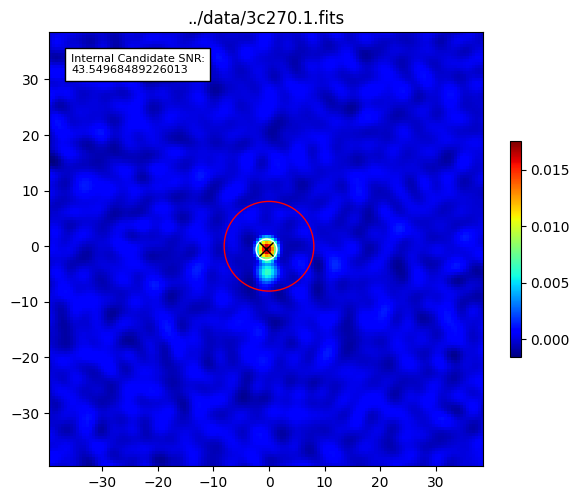

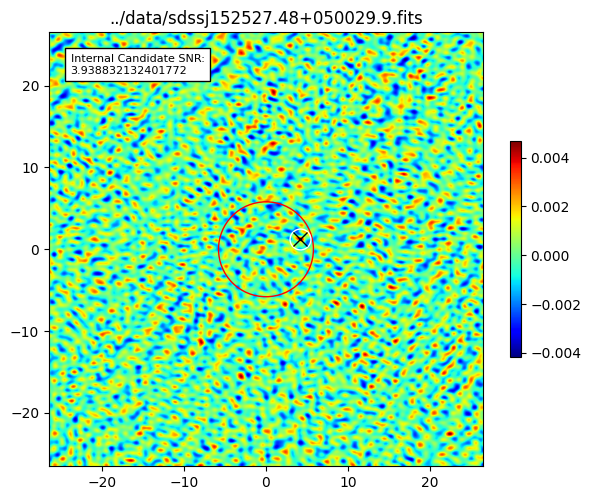

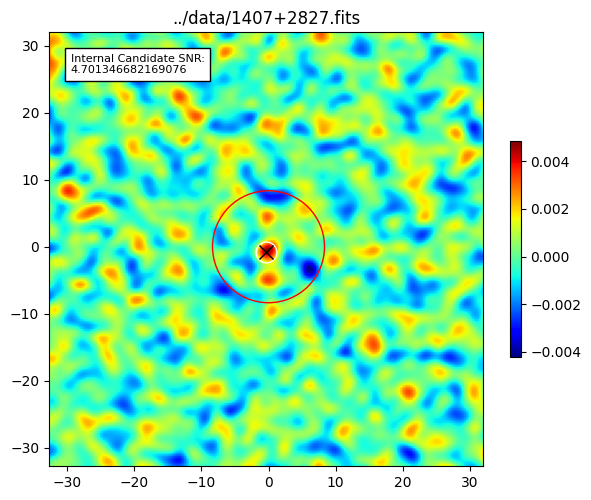

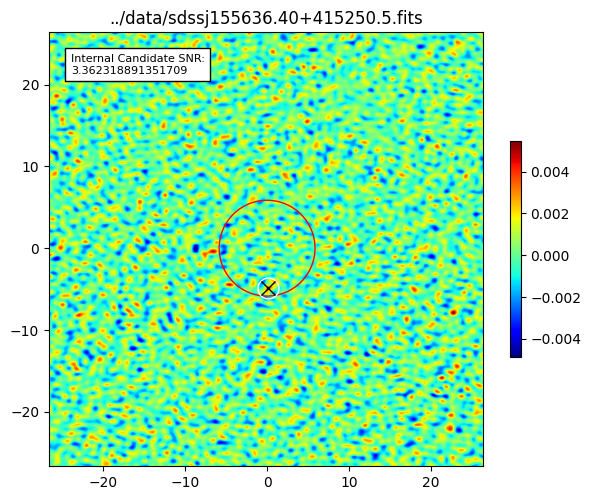

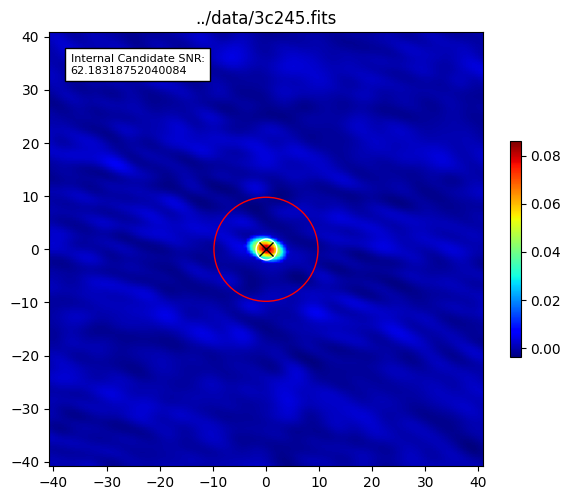

In [ ]:
#for file in glob.glob('../data/*.fits'):
    #try:
        #summary(file, False, False, True, '../data/figs_misc')
    #except Exception:
        #print('Try again for %s' %)

In [11]:
#for file in glob.glob('../data/multi_track/*.fits'):
    #try:
        #summary(file, False, False, True, '../data/multi_track/figs_multi_track')
    #except Exception:
        #print('Try again')